# Классификация изображений с помощью CNN

* Normal (healthy)
* Pneumonia

Набор данных был получен с сайта https://huggingface.co/datasets/trpakov/chest-xray-classification Полом Муни.

## Начало работы

Установите пакет ``huggingface_hub`` с помощью pip. \\
Импортируйте необходимые библиотеки:

In [61]:
!pip install huggingface_hub

In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import PIL
import matplotlib.pyplot as plt

## Скачать набор данных

Нам понадобится библиотека ``pathlib`` для работы с каталогами и ``hf_hub_download`` для загрузки набора данных с Hugging Face🤗.

In [63]:
import pathlib
from huggingface_hub import hf_hub_download
#hf_hub_download outputs a str
path_to_data = hf_hub_download(repo_id="trpakov/chest-xray-classification", local_dir = "/root/.keras/datasets/", filename="data/train.zip", repo_type="dataset")

Print out ```path_to_data```

/root/.keras/datasets/data\train.zip


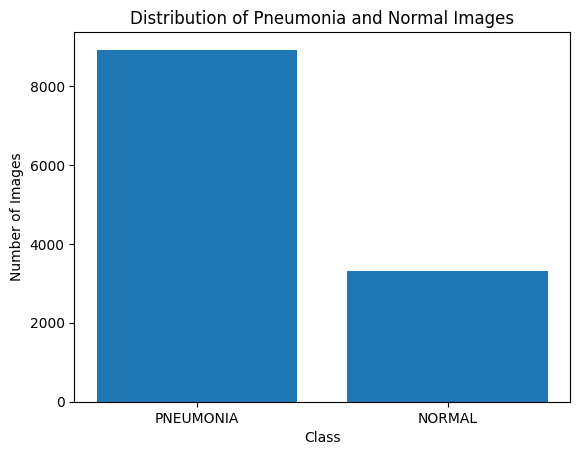

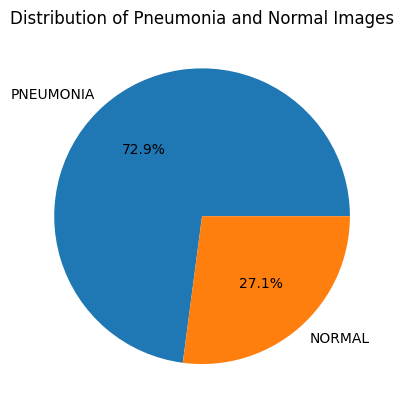

In [64]:
#Insert code here
print(path_to_data)
plt.bar(['PNEUMONIA', 'NORMAL'], [count_pneumonia, count_normal])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Pneumonia and Normal Images')
plt.show()

labels = ['PNEUMONIA', 'NORMAL']
sizes = [count_pneumonia, count_normal]

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of Pneumonia and Normal Images')
plt.show()

In [65]:
import zipfile
with zipfile.ZipFile(path_to_data, 'r') as training_archive:
  training_archive.extractall("/root/.keras/datasets/data/")

Найдите количество изображений в наборе данных. Вам потребуется импортировать библиотеки ``fnmatch`` и ``os``. После импорта выполните приведенный ниже код.

In [66]:
import os
import fnmatch

dir_path = r'/root/.keras/datasets/data/PNEUMONIA'
count_pneumonia = len(fnmatch.filter(os.listdir(dir_path), '*.jpg'))
print('Pneumonia images:', count_pneumonia)

dir_path = r'/root/.keras/datasets/data/NORMAL'
count_normal = len(fnmatch.filter(os.listdir(dir_path), '*.jpg'))
print('Normal images:', count_normal)


Pneumonia images: 8918
Normal images: 3312


Напишите код, который выводит общее количество изображений.

### Откройте изображение из набора данных

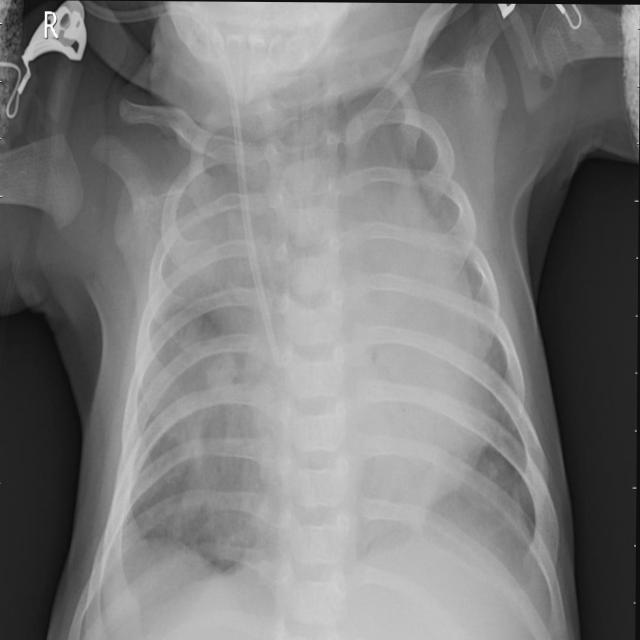

In [67]:
path_to_dataset = '/root/.keras/datasets/data/'
path_to_stuff = pathlib.Path('/root/.keras/datasets/data/').with_suffix('')
pneumonia = list(path_to_stuff.glob('PNEUMONIA/*')) #An array of paths to each x-ray image in the PNEUMONIA folder
PIL.Image.open(str(pneumonia[49]))

### Создайте набор данных

Определите размер партии, высоту и ширину рентгеновских лучей.
Изображения будут масштабироваться в зависимости от этих параметров. \\

Размер партии - это количество новых изображений, проходящих через сеть за один раз для обновления параметров модели. \\

За одну эпоху модель обновляется несколько раз. В каждом из этих обновлений количество используемых изображений равно размеру партии.

In [68]:
batch_size = 30
xray_height = 150
xray_width = 150

При разработке модели рекомендуется использовать валидационное разделение. Используйте 80 % изображений для обучения и 20 % для проверки. \\
Обучите модель, используя разделение 70:30 для обучения и проверки, а затем запустите ее снова, используя разделение 80:20.

In [69]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path_to_dataset,
  validation_split = 0.3,
  subset = "training",
  seed = 100, #Determines initial values of weights
  image_size = (xray_height, xray_width),
  batch_size = batch_size)



Found 12230 files belonging to 2 classes.
Using 8561 files for training.


In [70]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  path_to_dataset,
  validation_split = 0.3,
  subset = "validation",
  seed = 100, #Determines initial values of weights
  image_size = (xray_height, xray_width),
  batch_size = batch_size)

Found 12230 files belonging to 2 classes.
Using 3669 files for validation.


Имена классов можно найти в атрибуте `class_names` этих наборов данных. Они соответствуют именам каталогов в алфавитном порядке.

In [71]:
categories = train_ds.class_names
print(categories)

['NORMAL', 'PNEUMONIA']


## Просмотр набора данных

Покажите некоторые изображения из набора данных с метками с помощью ``matplotlib''.

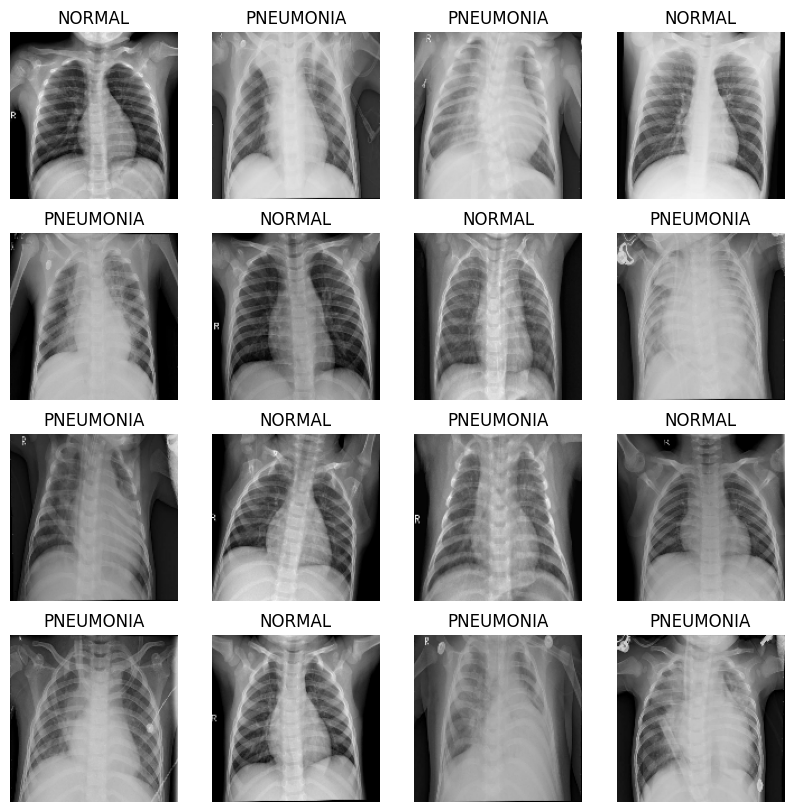

In [72]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(categories[labels[i]])
    plt.axis("off")

## Оптимизация набора данных для обучения

Следующий код оптимизирует обучение, загружая часть изображений в память, а не только загружая их с диска по мере необходимости. Это называется кэшированием.

Он также загружает из набора данных изображения для будущего шага обучения, пока выполняется текущий шаг обучения. Это называется предварительной выборкой.

In [73]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #Caching
valid_ds = valid_ds.cache().prefetch(buffer_size = AUTOTUNE) #Prefetching

## Нормализация значений каналов RGB

Цветное изображение содержит три целых числа для описания цвета каждого пикселя. Это красный, зеленый и синий каналы. Целое число каждого канала может находиться в диапазоне от 0 до 255. Нормализация изменяет масштаб целых чисел так, чтобы они изменялись от 0 до 1.

Добавьте приведенный ниже код в качестве первой строки под определением ``модели''.
```
layers.Rescaling(1./255, input_shape = (xray_height, xray_width, 3))
```

## Укажите слои

Модель использует три слоя свертки, а затем слой максимального объединения для каждого из них. Слой max pooling отвечает за то, чтобы модель фокусировалась на больших значениях.

In [74]:
num_classes = len(categories)

model = Sequential([
  
  layers.Conv2D(16, 3, padding = 'same', activation = 'relu'), #3 input channels, 16 output channels. 3x3 convolution kernel.
  layers.MaxPooling2D(), #Downsample 150x150 -> 75x75
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'), #16 input channels, 32 output channels. 3x3 convolution kernel.
  layers.MaxPooling2D(), #Downsample, 75x75 -> 37x37
  layers.Conv2D(64, 3, padding = 'same', activation = 'relu'), #32 input channels, 64 output channels. 3x3 convolution kernel.
  layers.MaxPooling2D(), #Downsample, 37x37 -> 18x18
  layers.Flatten(), #1 dimensional tensor, 18*18*64 = 20736 channels/parameters
  layers.Dense(128, activation = 'relu'), #1 dimensional tensor, 128 output channels. 128*(20736+1) = 2654336 parameters
  layers.Dense(num_classes) #1 dimensional tensor, 2 output channel (one for each category, NORMAL and PNEUMONIA). 
])

### Скомпилируйте модель

Используйте оптимизатор `tf.keras.optimizers.Adam` и функцию потерь `tf.keras.losses.SparseCategoricalCrossentropy`.

In [75]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [76]:
model.build(input_shape = (None, xray_height, xray_width, 3)) #3 input channels, 150x150 pixels

### Краткое описание модели

Используйте метод `Model.summary` для просмотра всех слоев, размеров и связанных с ними параметров.

In [77]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 18, 18, 64)       

### Обучите модель

Выполните приведенный ниже код для обучения модели:

In [78]:
epochs = 5
history = model.fit(
  train_ds,
  validation_data = valid_ds,
  epochs = epochs
)

Epoch 1/5


286/286 [==============================] - 93s 291ms/step - loss: 6.5351 - accuracy: 0.9073 - val_loss: 0.1263 - val_accuracy: 0.9569
Epoch 2/5
286/286 [==============================] - 84s 294ms/step - loss: 0.1367 - accuracy: 0.9525 - val_loss: 0.1393 - val_accuracy: 0.9496
Epoch 3/5
286/286 [==============================] - 83s 291ms/step - loss: 0.1122 - accuracy: 0.9576 - val_loss: 0.1407 - val_accuracy: 0.9477
Epoch 4/5
286/286 [==============================] - 87s 304ms/step - loss: 0.0589 - accuracy: 0.9779 - val_loss: 0.1530 - val_accuracy: 0.9417
Epoch 5/5
286/286 [==============================] - 93s 324ms/step - loss: 0.0530 - accuracy: 0.9799 - val_loss: 0.1029 - val_accuracy: 0.9646


## Анализ производительности модели

Создайте два графика:

1. Точность обучения в зависимости от эпохи
2. Точность проверки против эпохи

Хорошо ли работает модель? Объясните.

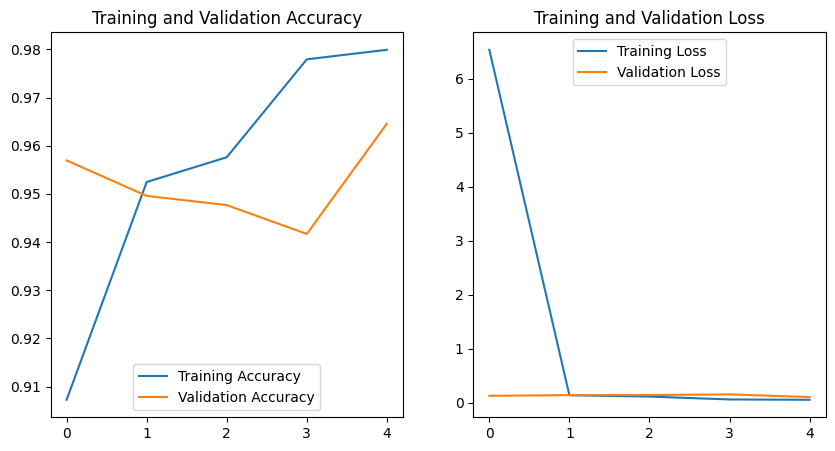

In [79]:
accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']

loss = history.history['loss']
valid_loss = history.history['val_loss']

no_of_epochs = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(no_of_epochs, accuracy, label='Training Accuracy')
plt.plot(no_of_epochs, valid_accuracy, label='Validation Accuracy')
plt.legend(loc='lower center')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(no_of_epochs, loss, label='Training Loss')
plt.plot(no_of_epochs, valid_loss, label='Validation Loss')
plt.legend(loc='upper center')
plt.title('Training and Validation Loss')
plt.show()

In [80]:
!pip install scikit-learn

## Прогнозирование на основе новых данных

Найдите рентгеновский снимок, которого не было ни в обучающем, ни в проверочном наборе данных. \\
Проверьте, может ли модель правильно различать здоровые и больные пневмонией легкие.

1/1 [==============================] - 0s 28ms/step
90.246% likely to be pneumonia


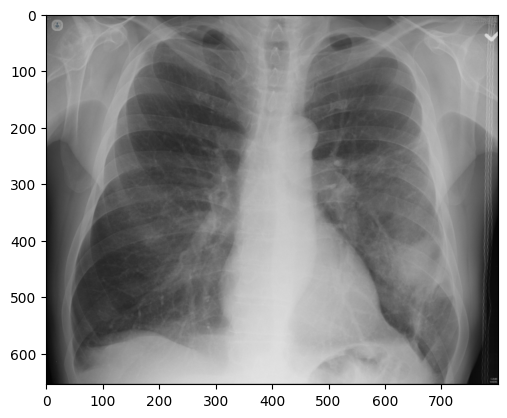

In [103]:
path_to_predict = './assets/5a536fd0-0d70-4b1d-be00-3c8e25bbab96.jpg'
predict = tf.keras.utils.load_img(
    path_to_predict, target_size=(xray_height, xray_width)
)

convert_to_array = tf.keras.utils.img_to_array(predict)
convert_to_array = tf.expand_dims(convert_to_array, 0)

prediction = model.predict(convert_to_array)
chance = tf.nn.softmax(prediction[0])

print("{:.3f}% likely to be {}".format(100 * np.max(chance), categories[np.argmax(chance)].lower()))
pil_img = PIL.Image.open(path_to_predict)
resized_image = pil_img.resize((150, 150))
image_array = np.array(resized_image) 
plt.imshow(pil_img)


In [ ]:
model.save('xray_model.h5')

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
